This is pulled from https://github.com/snap-stanford/ogb/tree/master/examples/lsc/pcqm4m

dependencies:
- install rdkit (I used conda) https://www.rdkit.org/docs/Install.html
1. conda create -c conda-forge -n my-rdkit-env rdkit
2. conda activate my-rdkit-env
3. cd [anaconda folder]/bin
4. source activate my-rdkit-env

- install ogb, torch and pytorch-geometric

- run the main-gnn.py code to download the dataset, extract and train (see the readme.md). I could finish extracting because my RAM wasn't enough. If you face the some problem, use this notebook to extract just a handful of the dataset. This code is taken from 

In [1]:
import os
import os.path as osp
import shutil
from ogb.utils import smiles2graph
from ogb.utils.torch_util import replace_numpy_with_torchtensor
from ogb.utils.url import decide_download, download_url, extract_zip
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch

from torch_geometric.data import InMemoryDataset
from torch_geometric.data import Data

In [2]:
"""
my folder structure looks like (obtained from running main_gnn)
dataset/
    pcqm4m_kddcup2021/
        mapping/
        processed/
        raw/
            data.csv.gz
"""

ROOT = "dataset/pcqm4m_kddcup2021"
filename = "{}/{}".format(ROOT, "raw/data.csv.gz")
data_df = pd.read_csv(filename)
data_df

,idx,smiles,homolumogap
0,0,Cc1ccc(cc1)C1C=c2cnccc2=NC1=O,3.047675
1,1,COc1cc(OC)ccc1C=CN(C(=O)C)C,4.410966
2,2,C=CCN(C(=O)C)C=Cc1ccccc1C,4.639541
3,3,C=CCN(C(=O)C)C=Cc1ccccc1F,4.492600
4,4,C=CCN(C(=O)C)C=Cc1ccccc1Cl,4.612330
...,...,...,...
3803448,3803448,O=N(=O)c1ccc(c(c1)N(=O)=O)Cl,NaN
3803449,3803449,NCC(=O)COP(=O)(O)O,NaN
3803450,3803450,CC(CN)O,NaN
3803451,3803451,OC1C=CC=C(C1O)C(=O)O,NaN


In [3]:
"""
Load Train/Test/Valid split dictionary
"""
# INPUT PARAMETERS HERE: SET TRAIN, TEST AND VAL SIZE
trainSize = 50000
testSize = 10000
valSize = 10000

# load raw split dict
split_dict = torch.load(osp.join(ROOT, 'split_dict.pt'))
# load new split dict
new_split_dict = split_dict.copy()

# sample new split dict
new_split_dict["train"] = np.random.choice(new_split_dict["train"], size=trainSize, replace=False)
new_split_dict["test"] = np.random.choice(new_split_dict["test"], size=testSize, replace=False)
new_split_dict["valid"] = np.random.choice(new_split_dict["valid"], size=valSize, replace=False)

In [4]:
# extract train, test and valid indices
sampleIndices = np.append(
    new_split_dict["train"], [new_split_dict["test"], new_split_dict["valid"]]
)

# remap indices
idMapping = {}
for i, index in enumerate(sampleIndices):
    idMapping[index] = i
    
idMapping

{467018: 0,
 1665498: 1,
 2270317: 2,
 1112350: 3,
 12576: 4,
 2249021: 5,
 1643273: 6,
 1052232: 7,
 1044128: 8,
 2332571: 9,
 1600896: 10,
 2789567: 11,
 2267813: 12,
 765225: 13,
 2175452: 14,
 723822: 15,
 923930: 16,
 700851: 17,
 841488: 18,
 1550197: 19,
 1369921: 20,
 1076275: 21,
 831203: 22,
 1330724: 23,
 1719515: 24,
 1954292: 25,
 711593: 26,
 1646361: 27,
 2323447: 28,
 1114803: 29,
 1612010: 30,
 874229: 31,
 329054: 32,
 1033649: 33,
 1630598: 34,
 2127805: 35,
 2541518: 36,
 1484320: 37,
 1248719: 38,
 2643552: 39,
 1797759: 40,
 333856: 41,
 1679935: 42,
 1051592: 43,
 3039753: 44,
 2393048: 45,
 76254: 46,
 2758004: 47,
 907773: 48,
 1258014: 49,
 1558610: 50,
 90473: 51,
 952969: 52,
 1037404: 53,
 1781593: 54,
 176170: 55,
 2276284: 56,
 214349: 57,
 2975080: 58,
 2611508: 59,
 2186309: 60,
 46754: 61,
 2595808: 62,
 2213158: 63,
 1220227: 64,
 2356895: 65,
 2954097: 66,
 1944516: 67,
 1149775: 68,
 1721103: 69,
 1950898: 70,
 2310341: 71,
 289795: 72,
 2577348: 73

In [5]:
"""
Save New Dataframe based on smaller samples
"""
# filter dataframe
sampleDF = data_df.iloc[sampleIndices]
sampleDF["old_idx"] = sampleDF["idx"]
# remap the index
sampleDF["idx"] = sampleDF["idx"].apply(lambda x: idMapping[x])
sampleDF.index = sampleDF["idx"]

# save sample dataframe
sampleDF.to_csv(osp.join(ROOT, "raw", "sample_data.csv.gz"))

sampleDF

<ipython-input-5-66f97a946e4f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampleDF["old_idx"] = sampleDF["idx"]
<ipython-input-5-66f97a946e4f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampleDF["idx"] = sampleDF["idx"].apply(lambda x: idMapping[x])


,idx,smiles,homolumogap,old_idx
idx,,,,
0,0,C=CCNc1ccc2c(c1)B(O)OC2,4.830021,467018
1,1,N#CC(CC(C)(C)C)[N+]#[C-],8.397433,1665498
2,2,O=C[C@@H](C(=O)c1cccc(c1)OC)CN(C)C,3.847690,2270317
3,3,CC(C(=O)Cc1onc(n1)C1CC1)C,5.915755,1112350
4,4,OC(=NC1CN2CCC1CC2)C=CC(=O)O,3.140194,12576
...,...,...,...,...
69995,69995,ClCc1ccccc1S(=O)C,4.990568,3204287
69996,69996,CN1CC2C(C1)(CCCC2)c1ccccc1,5.153836,3219703
69997,69997,[N-]=[N+]=NCCCCC1ON=C(C1)C(=O)O,5.393297,3340461


In [6]:
"""
Remap split_dict indices
"""
new_split_dict["train"] = np.array([idMapping[x] for x in new_split_dict["train"]])
new_split_dict["test"] = np.array([idMapping[x] for x in new_split_dict["test"]])
new_split_dict["valid"] = np.array([idMapping[x] for x in new_split_dict["valid"]])

torch.save(new_split_dict, osp.join(ROOT, "sample_split_dict.pt"))

## load data

In [7]:
from ogb.lsc import PygPCQM4MDataset, PCQM4MEvaluator

class SamplePygPCQM4MDataset(PygPCQM4MDataset):
    
    @property
    def raw_file_names(self):
        return 'sample_data.csv.gz'

    def process(self):
        # NOTE: CHANGED data.csv.gz to sample_data.csv.gz
        data_df = pd.read_csv(osp.join(self.raw_dir, 'sample_data.csv.gz'))
        smiles_list = data_df['smiles']
        homolumogap_list = data_df['homolumogap']

        print('Converting SMILES strings into graphs...')
        data_list = []
        for i in tqdm(range(len(smiles_list))):
            data = Data()

            smiles = smiles_list[i]
            homolumogap = homolumogap_list[i]
            graph = self.smiles2graph(smiles)
            
            assert(len(graph['edge_feat']) == graph['edge_index'].shape[1])
            assert(len(graph['node_feat']) == graph['num_nodes'])

            data.__num_nodes__ = int(graph['num_nodes'])
            data.edge_index = torch.from_numpy(graph['edge_index']).to(torch.int64)
            data.edge_attr = torch.from_numpy(graph['edge_feat']).to(torch.int64)
            data.x = torch.from_numpy(graph['node_feat']).to(torch.int64)
            data.y = torch.Tensor([homolumogap])

            data_list.append(data)

        # double-check prediction target
        split_dict = self.get_idx_split()
        assert(all([not torch.isnan(data_list[i].y)[0] for i in split_dict['train']]))
        assert(all([not torch.isnan(data_list[i].y)[0] for i in split_dict['valid']]))
        assert(all([torch.isnan(data_list[i].y)[0] for i in split_dict['test']]))

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        data, slices = self.collate(data_list)

        print('Saving...')
        torch.save((data, slices), self.processed_paths[0])
    
    # just modify the get_idx_split function to call our new filename
    def get_idx_split(self):
        # NOTE: CHANGED split_dict.pt to sample_split_dict.pt
        split_dict = replace_numpy_with_torchtensor(torch.load(osp.join(self.root, 'sample_split_dict.pt')))
        return split_dict

In [8]:
dataset = SamplePygPCQM4MDataset(root = 'dataset/')

  1%|          | 484/70000 [00:00<00:29, 2378.80it/s]

Processing...
Converting SMILES strings into graphs...


100%|██████████| 70000/70000 [00:30<00:00, 2333.12it/s]


Saving...
Done!


In [20]:
split_idx = dataset.get_idx_split()
split_idx["train"], split_idx["test"], split_idx["valid"]

(tensor([    0,     1,     2,  ..., 49997, 49998, 49999]),
 tensor([50000, 50001, 50002,  ..., 59997, 59998, 59999]),
 tensor([60000, 60001, 60002,  ..., 69997, 69998, 69999]))

In [15]:
evaluator = PCQM4MEvaluator()

In [28]:
import torch
from torch_geometric.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import StepLR

from gnn import GNN

import os
from tqdm import tqdm
import argparse
import time
import numpy as np
import random

In [273]:
# get args from main_gnn CLI
class Argument(object):
    name = "args"
    
args = Argument()
args.batch_size = 256
args.num_workers = 0
args.num_layers = 5
args.emb_dim = 600
args.drop_ratio = 0
args.graph_pooling = "sum"
args.checkpoint_dir = "checkpoint"

In [29]:
device = torch.device("cuda:" + str(args.device)) if torch.cuda.is_available() else torch.device("cpu")

In [25]:
train_loader = DataLoader(dataset[split_idx["train"]], batch_size=args.batch_size, shuffle=True, num_workers = args.num_workers)
valid_loader = DataLoader(dataset[split_idx["valid"]], batch_size=args.batch_size, shuffle=False, num_workers = args.num_workers)
test_loader = DataLoader(dataset[split_idx["test"]], batch_size=args.batch_size, shuffle=False, num_workers = args.num_workers)

In [27]:
shared_params = {
    'num_layers': args.num_layers,
    'emb_dim': args.emb_dim,
    'drop_ratio': args.drop_ratio,
    'graph_pooling': args.graph_pooling
}


BondEncoder is used to extract edge features. AtomEncoder is used to extract node features

In [67]:
import torch
from torch_geometric.nn import MessagePassing
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool, global_add_pool
from ogb.graphproppred.mol_encoder import AtomEncoder,BondEncoder
from torch_geometric.utils import degree

import math

# define GIN Convolution
class GINConv(MessagePassing):
    def __init__(self, emb_dim):
        super(GINConv, self).__init__(aggr="add")
        
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(emb_dim, emb_dim), 
            torch.nn.BatchNorm1d(emb_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(emb_dim, emb_dim)
        )
        self.eps = torch.nn.Parameter(torch.Tensor([0]))
        self.bond_encoder = BondEncoder(emb_dim=emb_dim)
        
    def forward(self, x, edge_index, edge_attr):
        # x is node features, edge_attr is edge attributes
        edge_embedding = self.bond_encoder(edge_attr)
        out = self.mlp((1 + self.eps) * x + self.propagate(edge_index, x=x, edge_attr=edge_embedding))
        
        return out
    
    def message(self, x_j, edge_attr):
        return F.relu(x_j + edge_attr)
    
    def update(self, aggr_out):
        return aggr_out
    
# define GCN Convolution
class GCNConv(MessagePassing):
    def __init__(self, emb_dim):
        super(GCNConv, self).__init__(aggr="add")
        
        self.linear = torch.nn.Linear(emb_dim, emb_dim)
        self.root_emb = torch.nn.Embedding(1, emb_dim)
        self.bond_encoder = BondEncoder(emb_dim=emb_dim)
        
    def forward(self, x, edge_index, edge_attr):
        x = self.linear(x)
        edge_embedding = self.bond_encoder(edge_attr)

        row, col = edge_index

        deg = degree(row, x.size(0), dtype=x.dtype) + 1
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0

        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        return self.propagate(edge_index, x=x, edge_attr=edge_embedding, norm=norm) + \
            F.relu(x + self.root_emb.weight) * 1./deg.view(-1, 1)

    def message(self, x_j, edge_attr, norm):
        return norm.view(-1, 1) * F.relu(x_j + edge_attr)
    
    def update(self, aggr_out):
        return aggr_out
    
# GNN for node embedding
class GNN_node(torch.nn.Module):
    def __init__(self, num_layers, emb_dim, drop_ratio=0.5, JK="last", residual=False, gnn_type="gin"):
        super(GNN_node, self).__init__()
        self.num_layers = num_layers
        self.drop_ratio = drop_ratio
        self.JK = JK
        # add residual connection or not
        self.residual = residual
        
        if self.num_layers < 2:
            raise ValueError("Number of GNN layers must be greater than 1")
            
        self.atom_encoder = AtomEncoder(emb_dim)
        
        # list of GNNs
        self.convs = torch.nn.ModuleList()
        self.batch_norms = torch.nn.ModuleList()
        for layer in range(num_layers):
            if gnn_type == "gin":
                self.convs.append(GINConv(emb_dim))
            elif gnn_type == "gcn":
                self.convs.append(GCNConv(emb_dim))
            else:
                ValueError("Undefined GNN type called {}".format(gnn_type))
                
            self.batch_norms.append(torch.nn.BatchNorm1d(emb_dim))
            
    def forward(self, batched_data):
        x, edge_index, edge_attr, batch = batched_data.x, batched_data.edge_index, batched_data.edge_attr, batched_data.batch
        
        # computing input node embedding
        h_list = [self.atom_encoder(x)]
        for layer in range(self.num_layers):
            # take the layer,
            h = self.convs[layer](h_list[layer], edge_index, edge_attr)
            h = self.batch_norms[layer](h)
            
            if layer == self.num_layers - 1:
                # remove relu for the last layer
                h = F.dropout(h, self.drop_ratio, training=self.training)
            else:
                h = F.dropout(F.relu(h), self.drop_ratio, training=self.training)
                
            if self.residual:
                h += h_list[layer]
        
            h_list.append(h)
            
        # different implementations of Jk-concat
        if self.JK == "last":
            node_representation = h_list[-1]
        elif self.JK == "sum":
            node_representation = 0
            for layer in range(self.num_layers):
                node_representation += h_list[layer]
                
        return node_representation
    

    class GNN_node_Virtualnode(torch.nn.Module):
        def __init__(self, num_layers, emb_dim, drop_ratio=0.5, JK="last", residual=False, gnn_type="gin"):
            super(GNN_node_Virtualnode, self).__init__()
            self.num_layers = num_layers
            self.drop_ratio = drop_ratio
            self.JK = JK
            # add residual connection or not
            self.residual = residual

            if self.num_layers < 2:
                raise ValueError("Number of GNN layers must be greater than 1")

            self.atom_encoder = AtomEncoder(emb_dim)

            # addition virtual node: set initial embedding to 0
            self.virtualnode_embedding = torch.nn.Embedding(1, emb_dim)
            torch.nn.init.constant_(self.virtualnode_embedding.weight.data, 0)
            
            # list of GNNs
            self.convs = torch.nn.ModuleList()
            self.batch_norms = torch.nn.ModuleList()
            for layer in range(num_layers):
                if gnn_type == "gin":
                    self.convs.append(GINConv(emb_dim))
                elif gnn_type == "gcn":
                    self.convs.append(GCNConv(emb_dim))
                else:
                    ValueError("Undefined GNN type called {}".format(gnn_type))

                self.batch_norms.append(torch.nn.BatchNorm1d(emb_dim))

            # addition list of mlps to transform virtual node
            self.mlp_virtualnode_list = torch.nn.ModuleList()
            for layer in range(num_layers - 1):
                self.mlp_virtualnode_list.append(
                    torch.nn.Sequential(
                        torch.nn.Linear(emb_dim, emb_dim), 
                        torch.nn.BatchNorm1d(emb_dim), 
                        torch.nn.ReLU(),
                        torch.nn.Linear(emb_dim, emb_dim), 
                        torch.nn.BatchNorm1d(emb_dim), 
                        torch.nn.ReLU()
                    )
                )
                
        def forward(self, batched_data):
            x, edge_index, edge_attr, batch = batched_data.x, batched_data.edge_index, batched_data.edge_attr, batched_data.batch

            ### virtual node embeddings for graphs
            virtualnode_embedding = self.virtualnode_embedding(torch.zeros(batch[-1].item()+1 ).to(edge_index.dtype).to(edge_index.device))

            # computing input node embedding
            h_list = [self.atom_encoder(x)]
            for layer in range(self.num_layers):
                # add message from virtual nodes to graph nodes
                h_list[layer] = h_list[layer] + virtualnode_embedding[batch]

                # take the layer,
                h = self.convs[layer](h_list[layer], edge_index, edge_attr)
                h = self.batch_norms[layer](h)

                if layer == self.num_layers - 1:
                    # remove relu for the last layer
                    h = F.dropout(h, self.drop_ratio, training=self.training)
                else:
                    h = F.dropout(F.relu(h), self.drop_ratio, training=self.training)

                if self.residual:
                    h += h_list[layer]

                h_list.append(h)

                ## update the virtual nodes
                if layer < self.num_layers - 1:
                    virtualnode_embedding_temp = global_add_pool(h_list[layer], batch) + virtualnode_embedding
                    if self.residual:
                        virtualnode_embedding = virtualnode_embedding + F.dropout(self.mlp_virtualnode_list[layer](virtualnode_embedding_temp), self.drop_ratio, training=self.training)
                    else:
                        virtualnode_embedding = F.dropout(self.mlp_virtualnode_list[layer](virtualnode_embedding_temp), self.drop_ratio, training=self.training)


            # different implementations of Jk-concat
            if self.JK == "last":
                node_representation = h_list[-1]
            elif self.JK == "sum":
                node_representation = 0
                for layer in range(self.num_layers):
                    node_representation += h_list[layer]

            return node_representation

In [64]:
"""
custom definition of model from examples.lsc.pcqm4m.gnn.GNN

Declare overall GNN. Dependent on Conv
"""

import torch
from torch_geometric.nn import MessagePassing
from torch_geometric.nn import global_add_pool, global_mean_pool, global_max_pool, GlobalAttention, Set2Set
import torch.nn.functional as F
from torch_geometric.nn.inits import uniform

# from conv import GNN_node, GNN_node_Virtualnode

from torch_scatter import scatter_mean


class GNN(torch.nn.Module):
    def __init__(self, num_tasks=1, num_layers=5, emb_dim=300,
                gnn_type="gin", virtual_node=True, residual=False,
                drop_ratio=0, JK="last", graph_pooling="sum"):
        super(GNN, self).__init__()
        
        self.num_layers = num_layers
        self.drop_ratio = drop_ratio
        self.JK = JK
        self.emb_dim = emb_dim
        self.num_tasks = num_tasks
        self.graph_pooling = graph_pooling
        
        # GNN to generate node embeddings
        if virtual_node:
            self.gnn_node = GNN_node_Virtualnode(num_layers, emb_dim, JK=JK, drop_ratio = drop_ratio, residual = residual, gnn_type = gnn_type)
        else:
            self.gnn_node = GNN_node(num_layers, emb_dim, JK=JK, drop_ratio = drop_ratio, residual = residual, gnn_type = gnn_type)

        # pooling function generate whole graph embeddings
        if self.graph_pooling == "sum":
            self.pool = global_add_pool
        elif self.graph_pooling == "mean":
            self.pool = global_mean_pool
        elif self.graph_pooling == "max":
            self.pool = global_max_pool
        elif self.graph_pooling == "attention":
            self.pool = GlobalAttention(gate_nn = torch.nn.Sequential(torch.nn.Linear(emb_dim, 2*emb_dim), torch.nn.BatchNorm1d(2*emb_dim), torch.nn.ReLU(), torch.nn.Linear(2*emb_dim, 1)))
        elif self.graph_pooling == "set2set":
            self.pool = Set2Set(emb_dim, processing_steps = 2)
        else:
            raise ValueError("Invalid graph pooling type.")

        if graph_pooling == "set2set":
            self.graph_pred_linear = torch.nn.Linear(2*self.emb_dim, self.num_tasks)
        else:
            self.graph_pred_linear = torch.nn.Linear(self.emb_dim, self.num_tasks)

            
    def forward(self, batched_data):
        # one layer
        h_node = self.gnn_node(batched_data)
        # pooling
        h_graph = self.pool(h_node, batched_data.batch)
        # regression layer
        output = self.graph_pred_linear(h_graph)
        
        if self.training:
            return output
        else:
            return torch.clamp(output, min=0, max=50)
        

In [68]:
reg_criterion = torch.nn.L1Loss()

model = GNN(gnn_type = 'gcn', virtual_node = False, **shared_params).to(device)

num_params = sum(p.numel() for p in model.parameters())
print(f'#Params: {num_params}')

optimizer = optim.Adam(model.parameters(), lr=0.001)

best_valid_mae = 1000

scheduler = StepLR(optimizer, step_size=300, gamma=0.25)

args.epochs = 1000


#Params: 1955401


In [59]:
def train(model, device, loader, optimizer):
    model.train()
    loss_accum = 0

    for step, batch in enumerate(tqdm(loader, desc="Iteration")):
        batch = batch.to(device)

        pred = model(batch).view(-1,)
        optimizer.zero_grad()
        loss = reg_criterion(pred, batch.y)
        loss.backward()
        optimizer.step()

        loss_accum += loss.detach().cpu().item()

    return loss_accum / (step + 1)

def eval(model, device, loader, evaluator):
    model.eval()
    y_true = []
    y_pred = []

    for step, batch in enumerate(tqdm(loader, desc="Iteration")):
        batch = batch.to(device)

        with torch.no_grad():
            pred = model(batch).view(-1,)

        y_true.append(batch.y.view(pred.shape).detach().cpu())
        y_pred.append(pred.detach().cpu())

    y_true = torch.cat(y_true, dim = 0)
    y_pred = torch.cat(y_pred, dim = 0)

    input_dict = {"y_true": y_true, "y_pred": y_pred}

    return evaluator.eval(input_dict)["mae"]

def test(model, device, loader):
    model.eval()
    y_pred = []

    for step, batch in enumerate(tqdm(loader, desc="Iteration")):
        batch = batch.to(device)

        with torch.no_grad():
            pred = model(batch).view(-1,)

        y_pred.append(pred.detach().cpu())

    y_pred = torch.cat(y_pred, dim = 0)

    return y_pred

In [69]:
for epoch in range(1, args.epochs + 1):
    print("=====Epoch {}".format(epoch))
    print('Training...')
    train_mae = train(model, device, train_loader, optimizer)

    print('Evaluating...')
    valid_mae = eval(model, device, valid_loader, evaluator)

    print({'Train': train_mae, 'Validation': valid_mae})

    if valid_mae < best_valid_mae:
        best_valid_mae = valid_mae

    scheduler.step()

    print(f'Best validation MAE so far: {best_valid_mae}')


Iteration:   0%|          | 0/196 [00:00<?, ?it/s]

=====Epoch 1
Training...


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/196 [00:00<?, ?it/s]

{'Train': 1.5572634086925157, 'Validation': 1.0945496559143066}
Best validation MAE so far: 1.0945496559143066
=====Epoch 2
Training...


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/196 [00:00<?, ?it/s]

{'Train': 0.7588038517504322, 'Validation': 0.9330750703811646}
Best validation MAE so far: 0.9330750703811646
=====Epoch 3
Training...


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/196 [00:00<?, ?it/s]

{'Train': 0.692919277719089, 'Validation': 1.0890164375305176}
Best validation MAE so far: 0.9330750703811646
=====Epoch 4
Training...


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/196 [00:00<?, ?it/s]

{'Train': 0.6438414682539142, 'Validation': 0.7747393846511841}
Best validation MAE so far: 0.7747393846511841
=====Epoch 5
Training...


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/196 [00:00<?, ?it/s]

{'Train': 0.6216269628125795, 'Validation': 0.9511856436729431}
Best validation MAE so far: 0.7747393846511841
=====Epoch 6
Training...


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/196 [00:00<?, ?it/s]

{'Train': 0.5923831173960044, 'Validation': 0.8758272528648376}
Best validation MAE so far: 0.7747393846511841
=====Epoch 7
Training...


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/196 [00:00<?, ?it/s]

{'Train': 0.5565038042104974, 'Validation': 0.7067475318908691}
Best validation MAE so far: 0.7067475318908691
=====Epoch 8
Training...


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/196 [00:00<?, ?it/s]

{'Train': 0.5396117218294922, 'Validation': 0.7744399905204773}
Best validation MAE so far: 0.7067475318908691
=====Epoch 9
Training...


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/196 [00:00<?, ?it/s]

{'Train': 0.5286431353615255, 'Validation': 0.74014812707901}
Best validation MAE so far: 0.7067475318908691
=====Epoch 10
Training...


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/196 [00:00<?, ?it/s]

{'Train': 0.519639076931136, 'Validation': 0.7978254556655884}
Best validation MAE so far: 0.7067475318908691
=====Epoch 11
Training...


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/196 [00:00<?, ?it/s]

{'Train': 0.49820628442934584, 'Validation': 0.6262657642364502}
Best validation MAE so far: 0.6262657642364502
=====Epoch 12
Training...


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/196 [00:00<?, ?it/s]

{'Train': 0.4800048703137709, 'Validation': 0.7028902769088745}
Best validation MAE so far: 0.6262657642364502
=====Epoch 13
Training...


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/196 [00:00<?, ?it/s]

{'Train': 0.47362797235956, 'Validation': 0.5732280611991882}
Best validation MAE so far: 0.5732280611991882
=====Epoch 14
Training...


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/196 [00:00<?, ?it/s]

{'Train': 0.4668943682799534, 'Validation': 0.8828573226928711}
Best validation MAE so far: 0.5732280611991882
=====Epoch 15
Training...


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/196 [00:00<?, ?it/s]

{'Train': 0.47219670001341374, 'Validation': 0.7283771634101868}
Best validation MAE so far: 0.5732280611991882
=====Epoch 16
Training...


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/196 [00:00<?, ?it/s]

{'Train': 0.4743766804434815, 'Validation': 0.7168417572975159}
Best validation MAE so far: 0.5732280611991882
=====Epoch 17
Training...


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/196 [00:00<?, ?it/s]

{'Train': 0.45403386257132705, 'Validation': 0.6079844236373901}
Best validation MAE so far: 0.5732280611991882
=====Epoch 18
Training...


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/196 [00:00<?, ?it/s]

{'Train': 0.4390478237551086, 'Validation': 0.5990612506866455}
Best validation MAE so far: 0.5732280611991882
=====Epoch 19
Training...


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating...


Iteration:   0%|          | 0/196 [00:00<?, ?it/s]

{'Train': 0.43352401636692944, 'Validation': 0.7532714605331421}
Best validation MAE so far: 0.5732280611991882
=====Epoch 20
Training...


Iteration:   5%|▌         | 10/196 [00:45<13:58,  4.51s/it]


KeyboardInterrupt: 

In [ ]:
# evaluate
eval(model, device, test_loader, evaluator)

In [277]:
"""
SAVE Checkpoint data
"""
checkpoint = {'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 'scheduler_state_dict': scheduler.state_dict(), 'best_val_mae': best_valid_mae, 'num_params': num_params}
torch.save(checkpoint, os.path.join(args.checkpoint_dir, 'checkpoint.pt'))

In [278]:
"""
LOAD Checkpoint data
"""
checkpoint = torch.load(os.path.join(args.checkpoint_dir, 'checkpoint.pt'))
checkpoint

{'epoch': 20,
 'model_state_dict': OrderedDict([('gnn_node.atom_encoder.atom_embedding_list.0.weight',
               tensor([[ 0.0205, -0.0231,  0.0487,  ...,  0.1295,  0.0452,  0.0804],
                       [-0.0607,  0.0126,  0.0327,  ..., -0.0729, -0.0406, -0.0119],
                       [ 0.0337, -0.0552,  0.0242,  ...,  0.0191,  0.0324, -0.0655],
                       ...,
                       [-0.0389,  0.0296, -0.0378,  ...,  0.0630, -0.0786, -0.0581],
                       [ 0.0038, -0.0828, -0.0541,  ...,  0.0448,  0.0460, -0.0059],
                       [ 0.0459, -0.0801, -0.0319,  ...,  0.0650,  0.0488,  0.0670]])),
              ('gnn_node.atom_encoder.atom_embedding_list.1.weight',
               tensor([[-0.0886,  0.0800, -0.0613,  ..., -0.0561,  0.0192, -0.0164],
                       [ 0.0840,  0.0616, -0.0311,  ..., -0.0773,  0.0503,  0.0236],
                       [ 0.0804,  0.1154,  0.0908,  ...,  0.0399,  0.0617, -0.0271],
                       [-0.0050,

In [281]:
"""
CODE to load model state dict
"""
# model2 = GNN(gnn_type = 'gcn', virtual_node = False, **shared_params).to(device)
# model2.load_state_dict(checkpoint["model_state_dict"])
# model2.state_dict()

OrderedDict([('gnn_node.atom_encoder.atom_embedding_list.0.weight',
              tensor([[ 0.0205, -0.0231,  0.0487,  ...,  0.1295,  0.0452,  0.0804],
                      [-0.0607,  0.0126,  0.0327,  ..., -0.0729, -0.0406, -0.0119],
                      [ 0.0337, -0.0552,  0.0242,  ...,  0.0191,  0.0324, -0.0655],
                      ...,
                      [-0.0389,  0.0296, -0.0378,  ...,  0.0630, -0.0786, -0.0581],
                      [ 0.0038, -0.0828, -0.0541,  ...,  0.0448,  0.0460, -0.0059],
                      [ 0.0459, -0.0801, -0.0319,  ...,  0.0650,  0.0488,  0.0670]])),
             ('gnn_node.atom_encoder.atom_embedding_list.1.weight',
              tensor([[-0.0886,  0.0800, -0.0613,  ..., -0.0561,  0.0192, -0.0164],
                      [ 0.0840,  0.0616, -0.0311,  ..., -0.0773,  0.0503,  0.0236],
                      [ 0.0804,  0.1154,  0.0908,  ...,  0.0399,  0.0617, -0.0271],
                      [-0.0050, -0.0281,  0.0833,  ...,  0.0620, -0.0633,  0.0

### visualise sample graphs

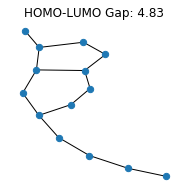

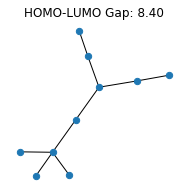

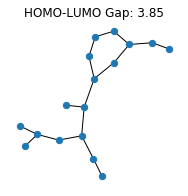

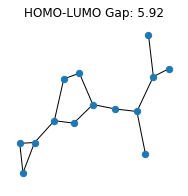

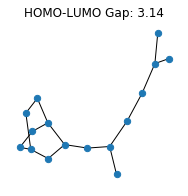

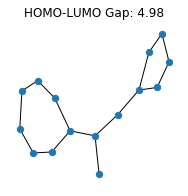

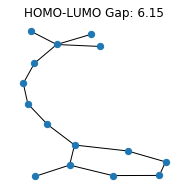

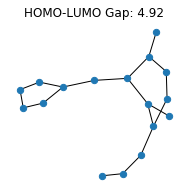

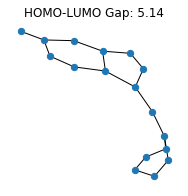

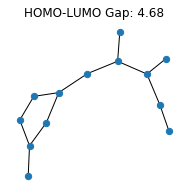

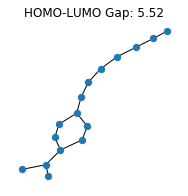

In [236]:
import networkx as nx
import matplotlib.pyplot as plt

def plotGraph(_data):
    edges = _data.edge_index.T.tolist()
    edges = np.array(edges)

    G = nx.Graph()
    G.add_edges_from(edges)

    plt.figure(figsize=(3, 3))
    plt.title("HOMO-LUMO Gap: {0:.2f}".format(_data.y.tolist()[0]))
    nx.draw(G, node_size=40)
    plt.show()

for i in range(11):
    
    _data = dataset[i]
    plotGraph(_data)

## visualise graph embeddings

In [ ]:
import seaborn as sns

In [210]:
"""
Get intermediate graph embeddings and visualise
"""

graphEmbeddings = None
y_true = []
for step, batch in enumerate(tqdm(valid_loader, desc="Iteration")):
    batch = batch.to(device)

    # get intermediate outputs
    h_node = model.gnn_node(batch)
    # GRAPH EMBEDDING
    h_graph = model.pool(h_node, batch.batch)
    output = model.graph_pred_linear(h_graph)

    # convert to numpy object
    h_graph_np = h_graph.detach().cpu().numpy()
    y_true.extend(batch.y.detach().cpu().numpy())

    if graphEmbeddings is None:
        graphEmbeddings = h_graph_np
    else:
        graphEmbeddings = np.concatenate((graphEmbeddings, h_graph_np))


Iteration: 100%|██████████| 40/40 [01:04<00:00,  1.62s/it]


(array([  29.,  226., 1781., 3716., 2662., 1128.,  366.,   76.,   12.,
           4.]),
 array([ 1.4476457,  2.5135157,  3.5793855,  4.6452556,  5.7111254,
         6.7769957,  7.8428655,  8.908735 ,  9.974606 , 11.040475 ,
        12.106345 ], dtype=float32),
 <a list of 10 Patch objects>)

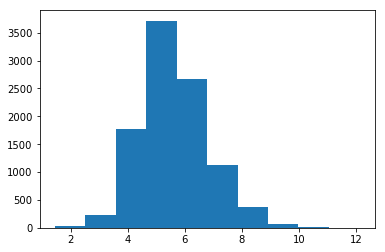

In [187]:
plt.hist(y_true)

((10000, 600), (10000, 2))

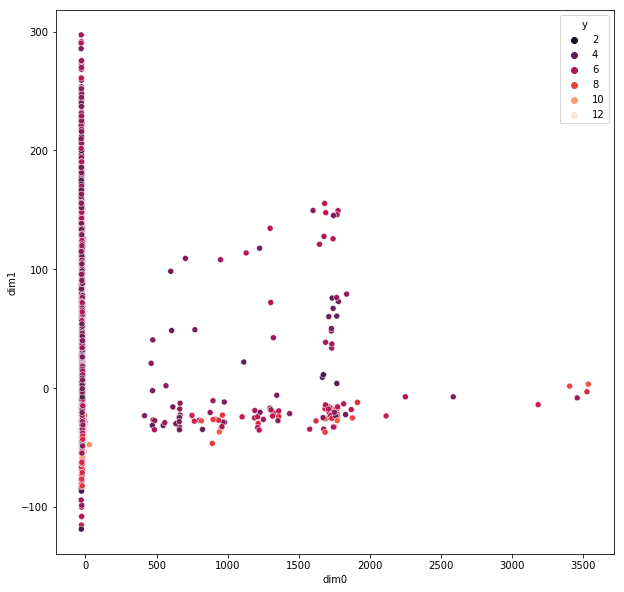

In [211]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(graphEmbeddings)

pcaEmb = pca.transform(graphEmbeddings)

pcaEmbDF = pd.DataFrame(pcaEmb, columns=["dim0", "dim1"])
pcaEmbDF["y"] = y_true

plt.figure(figsize=(10, 10))
sns.scatterplot(data=pcaEmbDF, x="dim0", y="dim1", hue="y", palette="rocket")


graphEmbeddings.shape, pcaEmb.shape

((10000, 600), (10000, 2))

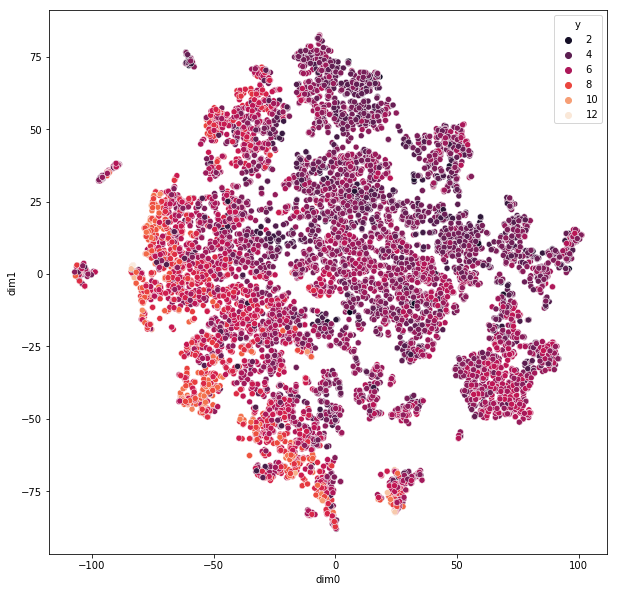

In [212]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)

tsneEmb = tsne.fit_transform(graphEmbeddings)

tsneEmbDF = pd.DataFrame(tsneEmb, columns=["dim0", "dim1"])
tsneEmbDF["y"] = y_true

plt.figure(figsize=(10, 10))
sns.scatterplot(data=tsneEmbDF, x="dim0", y="dim1", hue="y", palette="rocket")

graphEmbeddings.shape, tsneEmb.shape

## query graphs whose ys are very different, but embeddings are close

In [224]:
# add original data to embedding

valid_data_list = []
for batch in valid_loader:
    for i in range(batch.y.shape[0]):
        valid_data_list.append(batch[i])
        
tsneEmbDF["data"] = valid_data_list
tsneEmbDF

,dim0,dim1,y,data
0,-59.704060,-8.815238,6.917134,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,..."
1,16.607157,-14.740257,4.960636,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,..."
2,-68.942238,21.098127,7.094008,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,..."
3,-6.345589,67.687897,4.127967,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,..."
4,28.189486,-27.765053,4.808252,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,..."
...,...,...,...,...
9995,41.581181,-1.682599,4.990568,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,..."
9996,29.803705,-45.692577,5.153836,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,..."
9997,-32.852821,70.853951,5.393297,"[(edge_attr, [tensor([1, 0, 1]), tensor([1, 0,..."
9998,-22.361130,-60.927402,7.202854,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,..."


,dim0,dim1,y,data
5,-106.238411,-0.886124,8.593355,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,..."
174,-100.473282,-0.107629,6.220522,"[(edge_attr, [tensor([2, 0, 0]), tensor([2, 0,..."
218,-101.815628,-0.053296,4.315726,"[(edge_attr, [tensor([2, 0, 0]), tensor([2, 0,..."
362,-101.858833,0.800097,4.449061,"[(edge_attr, [tensor([2, 0, 0]), tensor([2, 0,..."
396,-81.530113,0.547717,8.707644,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,..."
...,...,...,...,...
9634,-106.757164,-0.698624,8.509000,"[(edge_attr, [tensor([2, 0, 0]), tensor([2, 0,..."
9745,-104.170181,1.860988,6.293993,"[(edge_attr, [tensor([2, 0, 0]), tensor([2, 0,..."
9913,-103.752686,2.799053,4.993289,"[(edge_attr, [tensor([2, 0, 0]), tensor([2, 0,..."
9947,-80.308075,-1.374045,7.436872,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,..."


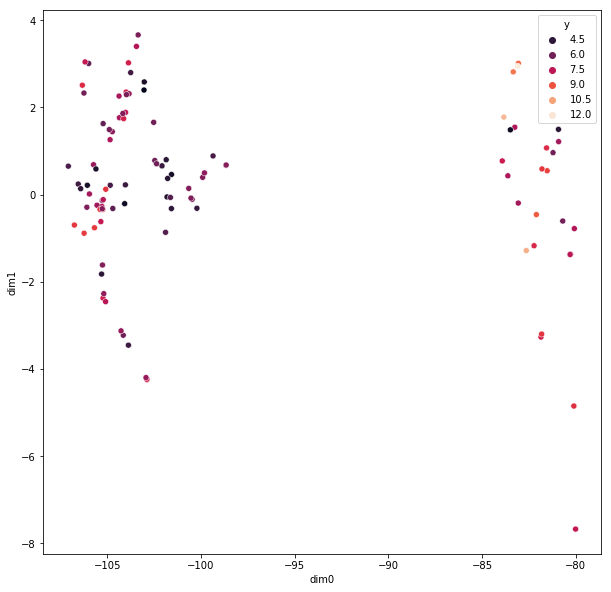

In [239]:
filtDF = tsneEmbDF[tsneEmbDF.dim0.apply(lambda x: -110 < x < -80) & tsneEmbDF.dim1.apply(lambda x: -10 < x < 10)]
# filtDF = tsneEmbDF[tsneEmbDF.dim0.apply(lambda x: -100 < x < -80) & tsneEmbDF.dim1.apply(lambda x: 25 < x < 50)]

plt.figure(figsize=(10, 10))
sns.scatterplot(data=filtDF, x="dim0", y="dim1", hue="y", palette="rocket")

filtDF

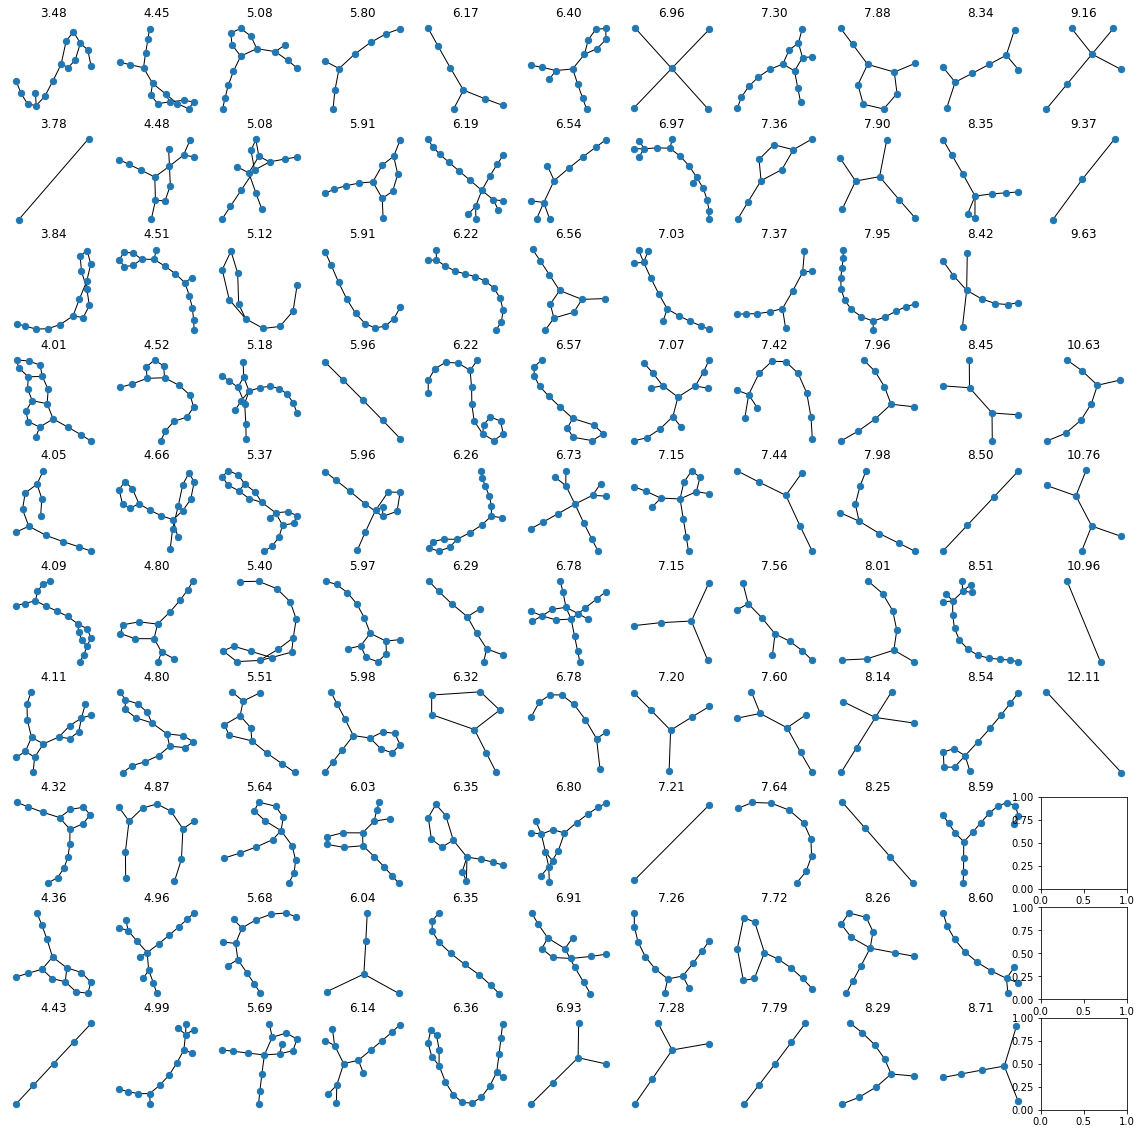

In [271]:
sizeX = 10
sizeY = int(filtDF.shape[0] / sizeX) + 1

fig, ax = plt.subplots(sizeX, sizeY,figsize=(20, 20))

i = 0
j = 0
for data in filtDF.sort_values("y")["data"]:
    edges = data.edge_index.T.tolist()
    edges = np.array(edges)

    G = nx.Graph()
    G.add_edges_from(edges)

    ax[i][j].set_title("{0:.2f}".format(data.y.tolist()[0]))
    nx.draw(G, node_size=40, ax=ax[i][j])

    i += 1
    if i == 10:
        i = 0
        j += 1

In [272]:

# for data in filtDF.sort_values("y")["data"]:
#     plotGraph(data)


see there are 2-nodes graphs whose topologies are similar but HOMO-LUMO gaps are very different (10.96, 12.11, 3.78) 

### debug

In [ ]:
# activation = {}
# def get_activation(name):
#     def hook(model, input, output):
#         activation[name] = output.detach()
#     return hook

In [ ]:
# model.gnn_node.convs[4].linear.register_forward_hook(get_activation("gnn_node.convs[4].linear"))
# model.graph_pred_linear.register_forward_hook(get_activation("model.graph_pred_linear"))

In [ ]:
# model.eval()
# y_pred = []
# y_true = []

# graph_pred_linear = []

# for step, batch in enumerate(tqdm(valid_loader, desc="Iteration")):
#     batch = batch.to(device)

#     with torch.no_grad():
#         pred = model(batch).view(-1,)
        
#     y_true.append(batch.y.view(pred.shape).detach().cpu().tolist())
# #     y_pred.append(pred.detach().cpu())

#     # 
#     graph_pred_linear.extend(activation["model.graph_pred_linear"].tolist())
        
#     break

In [ ]:
# activation['gnn_node.convs[4].linear']

In [ ]:
# activation["model.graph_pred_linear"].shape

In [ ]:
# # graph_pred_linear = activation["model.graph_pred_linear"].squeeze()
# # plt.hist(graph_pred_linear)

# plt.title("graph_pred_linear")
# plt.hist([x[0] for x in graph_pred_linear],alpha=0.3, label="pred")
# # plt.show()
# plt.hist(y_true, alpha=0.3, label="true")
# plt.legend()
# plt.show()